# NBA Roster Optimization using Constrained Optimization

## Import packages

In [1]:
!pip install pulp nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
import pulp
import nba_api
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
from nba_api.stats.endpoints import *
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll

## Import data

### Get NBA data from NBA_API

#### Custom Headers

In [4]:
# Use custom headers to resolve timeout issues with NBA API
headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

### Endpoint Data

#### commonteamroster

In [5]:
# # Get all teams
# teams_dict = teams.get_teams()

# # Get the team IDs
# team_ids = [team['id'] for team in teams_dict]

# # Initialize an empty list to store the individual team DataFrames
# team_dfs = []

# for team_id in team_ids:
#     # Request the roster for the current team
#     roster = commonteamroster.CommonTeamRoster(team_id)
    
#     # Get the data frame from the response
#     team_df = roster.get_data_frames()[0]
    
#     # Add the DataFrame to the list
#     team_dfs.append(team_df)
    
#     # Prevent hitting the rate limit by pausing before the next request
#     time.sleep(0.5)

# # Concatenate all the team DataFrames
# all_teams_df = pd.concat(team_dfs, ignore_index=True)

# # Print the DataFrame
# all_teams_df

In [6]:
all_teams_df = pd.read_excel('CommonTeamRoster_AllTeams.xlsx')
print(all_teams_df.shape)
all_teams_df.head()

(509, 16)


,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED
0,1610612737,2022,0,Donovan Williams,Donovan,donovan-williams,NaN,G,6-6,190,"SEP 06, 2001",21,R,UNLV,1631495,Signed on 01/17/23
1,1610612737,2022,0,Bruno Fernando,Bruno,bruno-fernando,0.0,F-C,6-10,240,"AUG 15, 1998",24,3,Maryland,1628981,Traded from HOU on 02/09/23
2,1610612737,2022,0,Jalen Johnson,Jalen,jalen-johnson,1.0,F,6-8,219,"DEC 18, 2001",21,1,Duke,1630552,#20 Pick in 2021 Draft
3,1610612737,2022,0,Trent Forrest,Trent,trent-forrest,2.0,G,6-4,210,"JUN 12, 1998",24,2,Florida State,1630235,Signed on 08/08/22
4,1610612737,2022,0,Aaron Holiday,Aaron,aaron-holiday,3.0,G,6-0,185,"SEP 30, 1996",26,4,UCLA,1628988,Signed on 07/06/22


#### leagueleaders

In [7]:
leagueleaders_df = leagueleaders.LeagueLeaders(per_mode48='PerGame', season=SeasonAll.current_season).get_data_frames()[0]
print(leagueleaders_df.shape)
leagueleaders_df.head()

(245, 25)


,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
0,203954,1,Joel Embiid,1610612755,PHI,66,34.6,11.0,20.1,0.548,1.0,3.0,0.330,10.0,11.7,0.857,1.7,8.4,10.2,4.2,1.0,1.7,3.4,33.1,35.9
1,1629029,2,Luka Doncic,1610612742,DAL,66,36.2,10.9,22.0,0.496,2.8,8.2,0.342,7.8,10.5,0.742,0.8,7.8,8.6,8.0,1.4,0.5,3.6,32.4,33.5
2,203081,3,Damian Lillard,1610612757,POR,58,36.3,9.6,20.7,0.463,4.2,11.3,0.371,8.8,9.6,0.914,0.8,4.0,4.8,7.3,0.9,0.3,3.3,32.2,30.2
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.5,10.4,20.3,0.510,0.9,2.5,0.345,9.8,10.9,0.905,0.9,4.0,4.8,5.5,1.6,1.0,2.8,31.4,30.5
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.1,11.2,20.3,0.553,0.7,2.7,0.275,7.9,12.3,0.645,2.2,9.6,11.8,5.7,0.8,0.8,3.9,31.1,32.9


### Import NBA salary data

Source: https://hoopshype.com/salaries/players/

In [8]:
salary_df = pd.read_csv('NBA-Salaries_22-23.csv')
salary_df.head()

,PLAYER,2022-2023,2023-2024,2024-2025,2025-2026
0,Stephen Curry,48070014,51915615,55761217,59606817
1,John Wall,47345760,0,0,0
2,Russell Westbrook,47080179,0,0,0
3,LeBron James,44474988,46698737,50434636,0
4,Kevin Durant,44119845,47649433,51179020,54708608


## Data Preparation

#### Re-map the NBA-API position data to fit DraftKings positions

In [9]:
position_df = all_teams_df.copy()

In [10]:
# Position data is different than DFS contests so reconciliation is needed
position_df['POSITION'].unique()

array(['G', 'F-C', 'F', 'F-G', 'C', 'G-F', 'C-F'], dtype=object)

In [11]:
# Create a mapping to reconcile API data with DFS contest positions
position_mapping = {
    'G': ['PG', 'SG', 'G', 'Util'],
    'F': ['SF', 'PF', 'F', 'Util'],
    'C': ['C', 'Util'],
    'F-C': ['PF', 'C', 'F', 'Util'],
    'F-G': ['SF', 'PF', 'PG', 'SG', 'G', 'F', 'Util'],
    'G-F': ['PG', 'SG', 'SF', 'PF', 'G', 'F', 'Util'],
    'C-F': ['C', 'PF', 'F', 'Util']
}

In [12]:
# Remap the API data with the DFS contest positions
player_positions = []
for i, row in position_df.iterrows():
    player = row['PLAYER']
    player_id = row['PLAYER_ID']
    api_position = row['POSITION']
    contest_positions = position_mapping[api_position]
    for pos in contest_positions:
        player_positions.append({'PLAYER': player,
                                 'PLAYER_ID': player_id, 
                                 'POSITION': pos})

# Convert the list of dictionaries to a DataFrame
df_mapped_positions = pd.DataFrame(player_positions)
df_mapped_positions

,PLAYER,PLAYER_ID,POSITION
0,Donovan Williams,1631495,PG
1,Donovan Williams,1631495,SG
2,Donovan Williams,1631495,G
3,Donovan Williams,1631495,Util
4,Bruno Fernando,1628981,PF
...,...,...,...
2111,Kobi Simmons,1628424,Util
2112,P.J. Washington,1629023,SF
2113,P.J. Washington,1629023,PF
2114,P.J. Washington,1629023,F


### Clean up the salary dataframe

In [13]:
# Only using one column
salary_df = salary_df[['PLAYER', '2022-2023']]

# Create a re-scaled version of the salary column for DFS contest
min_old = salary_df['2022-2023'].min()
max_old = salary_df['2022-2023'].max()

# Min salary is 2,500 and max salary is 10,000
min_new = 2500
max_new = 10000

# Create the new column
salary_df['COST'] = ((salary_df['2022-2023'] - min_old) / (max_old - min_old)) * (max_new - min_new) + min_new
salary_df.head()

<ipython-input-13-0b672a65f279>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['COST'] = ((salary_df['2022-2023'] - min_old) / (max_old - min_old)) * (max_new - min_new) + min_new


,PLAYER,2022-2023,COST
0,Stephen Curry,48070014,10000.000000
1,John Wall,47345760,9886.986386
2,Russell Westbrook,47080179,9845.544753
3,LeBron James,44474988,9439.027080
4,Kevin Durant,44119845,9383.610066


### Merge NBA_API data

In [14]:
# Get a dataframe with newly mapped positions and NBA player data
players_df = pd.merge(df_mapped_positions, leagueleaders_df,  on=['PLAYER_ID', 'PLAYER'], how='left')
print(players_df.shape)
players_df.head()

(2116, 26)


,PLAYER,PLAYER_ID,POSITION,RANK,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
0,Donovan Williams,1631495,PG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Donovan Williams,1631495,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Donovan Williams,1631495,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Donovan Williams,1631495,Util,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bruno Fernando,1628981,PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge Salary data

In [15]:
players_df = pd.merge(players_df, salary_df, on='PLAYER', how='inner')
print(players_df.shape)
players_df.head()

(1880, 28)


,PLAYER,PLAYER_ID,POSITION,RANK,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,2022-2023,COST
0,Donovan Williams,1631495,PG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476
1,Donovan Williams,1631495,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476
2,Donovan Williams,1631495,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476
3,Donovan Williams,1631495,Util,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476
4,Bruno Fernando,1628981,PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2717391,2923.112833


### Calculate Fantasy Points

In [16]:
# Create a function to caluclate ProjectedPoints
def calc_fantasypoints(df):
    df['PROJECTED_POINTS'] = 1*df['PTS'] + 1.2*df['REB'] + 1.5*df['AST'] + 3*df['STL'] + 3*df['BLK'] - 1*df['TOV']
    return df

In [17]:
# Calculate the fantasy points column 
players_df = calc_fantasypoints(players_df)
print(players_df.shape)
players_df.head()

(1880, 29)


,PLAYER,PLAYER_ID,POSITION,RANK,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,2022-2023,COST,PROJECTED_POINTS
0,Donovan Williams,1631495,PG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476,NaN
1,Donovan Williams,1631495,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476,NaN
2,Donovan Williams,1631495,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476,NaN
3,Donovan Williams,1631495,Util,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239822,2536.509476,NaN
4,Bruno Fernando,1628981,PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2717391,2923.112833,NaN


### Drop the null values for integer programming

In [18]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 1879
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PLAYER            1880 non-null   object 
 1   PLAYER_ID         1880 non-null   int64  
 2   POSITION          1880 non-null   object 
 3   RANK              934 non-null    float64
 4   TEAM_ID           934 non-null    float64
 5   TEAM              934 non-null    object 
 6   GP                934 non-null    float64
 7   MIN               934 non-null    float64
 8   FGM               934 non-null    float64
 9   FGA               934 non-null    float64
 10  FG_PCT            934 non-null    float64
 11  FG3M              934 non-null    float64
 12  FG3A              934 non-null    float64
 13  FG3_PCT           934 non-null    float64
 14  FTM               934 non-null    float64
 15  FTA               934 non-null    float64
 16  FT_PCT            934 non-null    float64


In [19]:
players_df = players_df.dropna()
print(players_df.shape)
players_df.head()

(934, 29)


,PLAYER,PLAYER_ID,POSITION,RANK,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,2022-2023,COST,PROJECTED_POINTS
8,Jalen Johnson,1630552,SF,220.0,1.610613e+09,ATL,70.0,14.9,2.3,4.6,0.491,0.4,1.5,0.288,0.7,1.1,0.628,0.7,3.3,4.0,1.2,0.5,0.5,0.6,5.6,8.5,2792640,2934.854793,14.60
9,Jalen Johnson,1630552,PF,220.0,1.610613e+09,ATL,70.0,14.9,2.3,4.6,0.491,0.4,1.5,0.288,0.7,1.1,0.628,0.7,3.3,4.0,1.2,0.5,0.5,0.6,5.6,8.5,2792640,2934.854793,14.60
10,Jalen Johnson,1630552,F,220.0,1.610613e+09,ATL,70.0,14.9,2.3,4.6,0.491,0.4,1.5,0.288,0.7,1.1,0.628,0.7,3.3,4.0,1.2,0.5,0.5,0.6,5.6,8.5,2792640,2934.854793,14.60
11,Jalen Johnson,1630552,Util,220.0,1.610613e+09,ATL,70.0,14.9,2.3,4.6,0.491,0.4,1.5,0.288,0.7,1.1,0.628,0.7,3.3,4.0,1.2,0.5,0.5,0.6,5.6,8.5,2792640,2934.854793,14.60
16,Aaron Holiday,1628988,PG,237.0,1.610613e+09,ATL,63.0,13.4,1.5,3.5,0.418,0.6,1.4,0.409,0.4,0.5,0.844,0.4,0.8,1.2,1.4,0.6,0.2,0.6,3.9,4.6,1968175,2806.204113,9.24


### Remove unnecessary columns for final dataframe

In [20]:
min_cols = ['PLAYER', 'PLAYER_ID', 'POSITION', 'COST', 'PROJECTED_POINTS']

df_prep = players_df[min_cols]
df_prep.head()

,PLAYER,PLAYER_ID,POSITION,COST,PROJECTED_POINTS
8,Jalen Johnson,1630552,SF,2934.854793,14.60
9,Jalen Johnson,1630552,PF,2934.854793,14.60
10,Jalen Johnson,1630552,F,2934.854793,14.60
11,Jalen Johnson,1630552,Util,2934.854793,14.60
16,Aaron Holiday,1628988,PG,2806.204113,9.24


## Exploratory Data Analysis

For the knapsack problem, I will most likely use this dataset or something similar. I have queried the NBA_API to grab player statistics for the current season. 

It took a little bit of time to understand how to properly use the NBA_API. I ran into issues at first while trying to grab player data for the entire league. Initially, I created a for loop that would query the API for individual player statistics and then try to use Pandas to create a dataframe. The Python program would run into timeout issues from the API, as it most likely would not allow me to make so many requests at once. After browsing almost all the endpoints, I found an alternative endpoint which would give me player statistics for the entire league, `leagueleaders`.

During data preparation, I calculated a new column called, `AVG_FANTASY_PTS` which will be used in the objective function of the optimization problem. The objective function will be used to maximize the total number of fantasy points a team can earn. In addition, I have also merged a salary dataset in order to define a constraint to be used in the optimization problem. The players will represent the decision variables in the optimization problem and they will be represented as binary variables, where 1 indicates a player is selected and 0 indicating a player is not selected.

Finally, I checked the two columns that I was most interested in the optimization problem and visualized them in a scatterplot below. So far there seems to be a positive correlation between a player's average fantasy points and their respective NBA salary. This is expected as one would assume that the highest ranked points scorers also receive the largest contracts in the NBA.

### Scatterplot

y = 120.17518732884048x + 1367.3415954392506


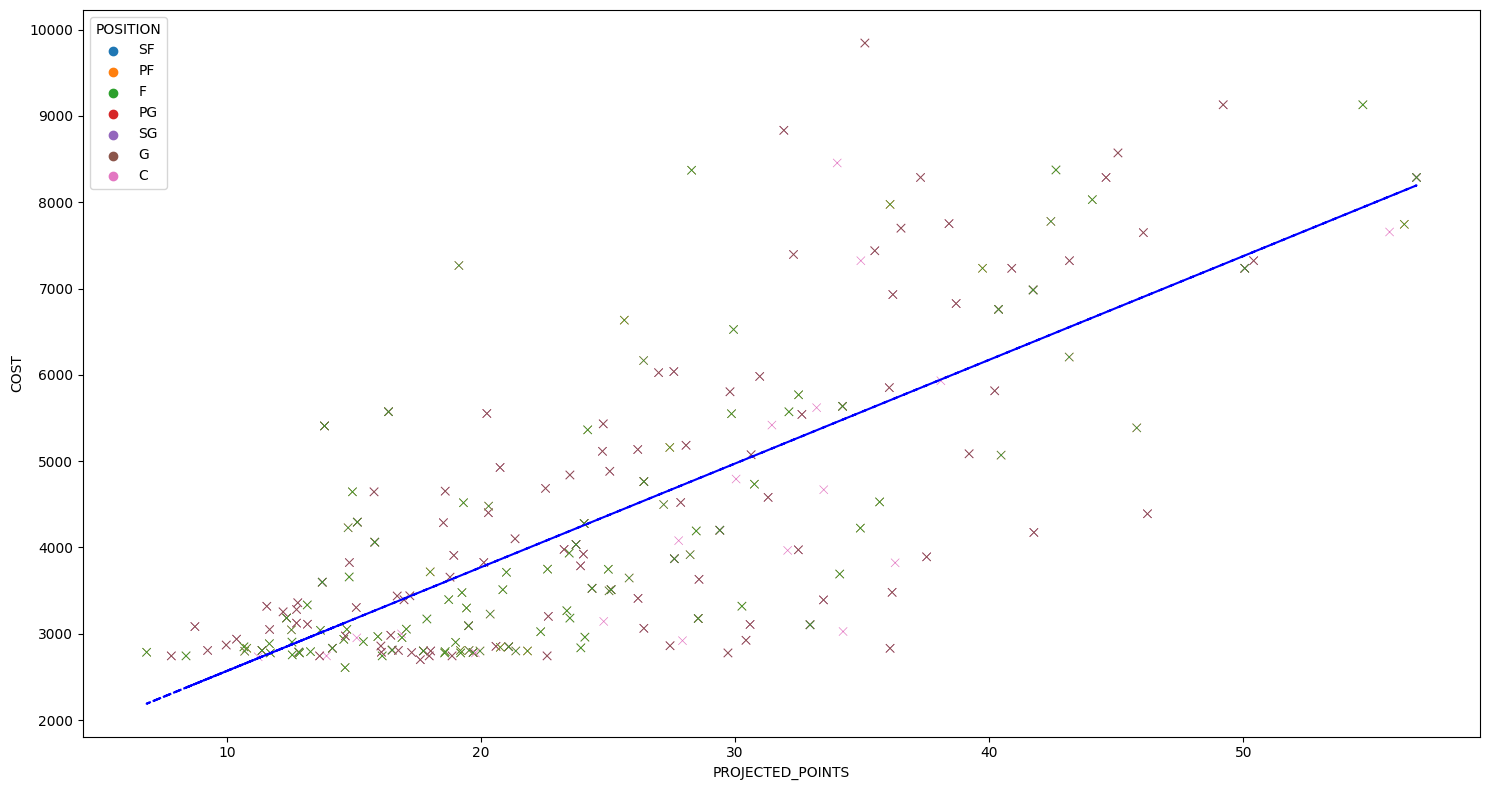

In [21]:
# Make a copy of the players dataframe
plot_df = players_df.copy()

# Remove the Util position, noisy data
filters = (~plot_df['POSITION'].isin(['Util']))
plot_df = plot_df[filters]

# Set fig parameters
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True

# Create a scatterplot of average fantasy points by salary
ax = sns.scatterplot(data=plot_df, x='PROJECTED_POINTS', 
                                   y='COST',
                                   hue='POSITION',
                                   marker='x')
# Calculate the trendline
z = np.polyfit(plot_df['PROJECTED_POINTS'], plot_df['COST'], 1)
p = np.poly1d(z)

# Plot the trendline
plt.plot(plot_df['PROJECTED_POINTS'], p(plot_df['PROJECTED_POINTS']), "b--")

# The line equation
print(f"y = {z[0]}x + {z[1]}")

# Show the plot
plt.show()

## Roster Optimization with Integer Programming



In [22]:
# Set a budget cap of $50,000
salary_cap = 50000

# Create a binary variable to represent whether each player is selected.
player_vars = {}
for i, row in df_prep.iterrows():
    player_vars[(row['PLAYER'], row['POSITION'])] = LpVariable(name=f"Player_{row['PLAYER']}_{row['POSITION']}", cat='Binary')

# Define the problem
model = LpProblem("DailyFantasySports_Contest", LpMaximize)

# Create the objective function
model += lpSum([player_vars[(row['PLAYER'], row['POSITION'])] * row['PROJECTED_POINTS'] for i, row in df_prep.iterrows()])

# Create the cost constraint
model += lpSum([player_vars[(row['PLAYER'], row['POSITION'])] * row['COST'] for i, row in df_prep.iterrows()]) <= salary_cap

# Create the positional constraints
position_requirements = {
    'PG': 1,
    'SG': 1,
    'SF': 1,
    'PF': 1,
    'C': 1,
    'G': 1,   # G can be either PG or SG
    'F': 1,   # F can be either SF or PF
    'Util': 1 # UTIL can be any of G, F, or C
}

for position in df_prep['POSITION'].unique():
    model += lpSum([player_vars[(player, pos)] for player, pos in player_vars.keys() if pos == position]) == position_requirements[position]

# Create the constraint that each player can be selected at most once
for player in df_prep['PLAYER'].unique():
    model += lpSum([player_vars[(p, position)] for p, position in player_vars.keys() if p == player]) <= 1

# Solve the model
model.solve()

# Print the results
selected_players = []

for v in model.variables():
    if v.varValue == 1:
        print(v.name, "=", v.varValue)
        selected_players.append(v.name)

print("Projected Fantasy Points = ", value(model.objective))

Player_Anthony_Edwards_G = 1.0
Player_Desmond_Bane_Util = 1.0
Player_Domantas_Sabonis_F = 1.0
Player_Giannis_Antetokounmpo_SF = 1.0
Player_Ja_Morant_SG = 1.0
Player_Joel_Embiid_PF = 1.0
Player_Luka_Doncic_PG = 1.0
Player_Nikola_Jokic_C = 1.0
Projected Fantasy Points =  393.53000000000003
